In [1]:
import os
from collections.abc import Iterator
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
from neuralop import LpLoss
from neuralop.models import FNO
from neuralop.training import Trainer
from sklearn.decomposition import PCA

from panda.utils.data_utils import safe_standardize
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

vfield = np.load(fpath, allow_pickle=True)
vx = vfield[..., 0]
vy = vfield[..., 1]
dvx = np.gradient(vx, 2 / vx.shape[1], axis=2)
dvy = np.gradient(vy, 1 / vy.shape[2], axis=1)
vort_field = dvy + dvx
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

In [ ]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

In [4]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

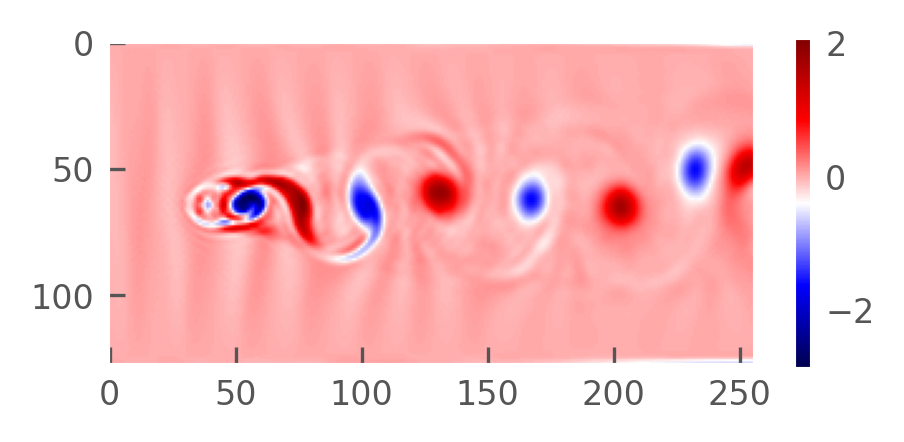

In [5]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

In [6]:
start_times = np.arange(0, 4096, 1024)
n_runs = len(start_times)
start_times = start_times.astype(int)
print(f"{len(start_times)} start_times: {start_times}")

4 start_times: [   0 1024 2048 3072]


In [7]:
stride = 1
context_length = 512
prediction_length = 512

In [ ]:
trajs = np.stack([X_ts[start : start + context_length + prediction_length : stride] for start in start_times], axis=0)

In [ ]:
@dataclass
class Dataset(torch.utils.data.Dataset):
    trajs: torch.Tensor  # shape: (num_trajs, T, N)
    context_length: int = 1

    def __len__(self) -> int:
        return self.trajs.shape[0] * (self.trajs.shape[1] - self.context_length)

    def __getitem__(self, idx: int) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        traj_idx = idx // (self.trajs.shape[1] - self.context_length)
        i = idx % (self.trajs.shape[1] - self.context_length)
        x = self.trajs[traj_idx, i : i + self.context_length]
        y = self.trajs[traj_idx, i + self.context_length]
        if y.ndim == 1:
            y = y[np.newaxis, :]
        if x.ndim == 1:
            x = x[np.newaxis, :]
        return {
            "x": torch.from_numpy(x).float(),
            "y": torch.from_numpy(y).float(),
        }


device_rank = 2
device = f"cuda:{device_rank}"

stand_trajs = safe_standardize(trajs, axis=1, context=trajs[:, :context_length])
context_window = stand_trajs[:, :context_length]
prediction_window = stand_trajs[:, context_length:]

num_epochs = 5000
batch_size = 512

# preprocess training context
lookback = 8
train_dataset = Dataset(context_window, context_length=lookback)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    Dataset(prediction_window, context_length=lookback),
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
)


operator = FNO(n_modes=(512,), hidden_channels=256, n_layers=5, in_channels=lookback, out_channels=1).to(device)
trainer = Trainer(model=operator, n_epochs=num_epochs, verbose=True, device=device)
optimizer = torch.optim.AdamW(operator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataset) * num_epochs)
loss_fn = LpLoss(d=1)

trainer.train(
    train_loader=train_loader,
    test_loaders={"eval": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    training_loss=loss_fn,
    save_every=1000,
    save_dir="./vkvs_ckpt",
    save_best="eval_l2",
)

Training on 2032 samples
Testing on [2032] samples         on resolutions ['eval'].


Raw outputs of shape torch.Size([512, 1, 128])
[0] time=0.11, avg_loss=0.9914, train_err=503.6324
Eval: eval_l2=0.9628


/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/neuralop/training/trainer.py:536: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[Rank 0]: saved training state to ./vkvs_ckpt
[1] time=0.06, avg_loss=0.9072, train_err=460.8460
Eval: eval_l2=0.8565
[Rank 0]: saved training state to ./vkvs_ckpt
[2] time=0.06, avg_loss=0.7997, train_err=406.2497
Eval: eval_l2=0.7499
[Rank 0]: saved training state to ./vkvs_ckpt
[3] time=0.06, avg_loss=0.7120, train_err=361.7084
Eval: eval_l2=0.6930
[Rank 0]: saved training state to ./vkvs_ckpt
[4] time=0.06, avg_loss=0.6549, train_err=332.6888
Eval: eval_l2=0.6330
[Rank 0]: saved training state to ./vkvs_ckpt
[5] time=0.06, avg_loss=0.6116, train_err=310.6907
Eval: eval_l2=0.5981
[Rank 0]: saved training state to ./vkvs_ckpt
[6] time=0.06, avg_loss=0.5743, train_err=291.7291
Eval: eval_l2=0.5607
[Rank 0]: saved training state to ./vkvs_ckpt
[7] time=0.06, avg_loss=0.5399, train_err=274.2815
Eval: eval_l2=0.5224
[Rank 0]: saved training state to ./vkvs_ckpt
[8] time=0.06, avg_loss=0.5055, train_err=256.7998
Eval: eval_l2=0.4921
[Rank 0]: saved training state to ./vkvs_ckpt
[9] time=0

{'train_err': 8.03699815273285,
 'avg_loss': 0.015820862505379625,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.05872243799967691,
 'eval_l2': tensor(0.2197, device='cuda:2')}

In [43]:
def rollout(ic: torch.Tensor, num_steps: int, model: torch.nn.Module) -> torch.Tensor:
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        pred = model(state)
        traj.append(pred)
        state = torch.cat([state[:, :-1, :], pred], dim=1)
    return torch.cat(traj, dim=1)

In [44]:
# load best model
WORK_DIR = os.path.expandvars("$WORK")
operator.load_state_dict(
    # torch.load(f"{WORK_DIR}/checkpoints/VKVS_baselines/best_model_state_dict.pt", map_location=device, weights_only=False)
    torch.load("vkvs_ckpt/best_model_state_dict.pt", map_location=device, weights_only=False)
)
operator.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-4): 5 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([128, 128, 33]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-4): 5 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-4): 5 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-4): 5 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 1, kern

In [45]:
# sample prediction
prediction = (
    rollout(
        torch.from_numpy(context_window[0, -lookback:]).float().to(device).unsqueeze(0),
        model=operator,
        num_steps=prediction_length,
    )
    .squeeze()[lookback:]
    .detach()
    .cpu()
    .numpy()
)
prediction = safe_standardize(prediction, axis=0, context=trajs[0, :context_length], denormalize=True)

In [46]:
def plot_predicted_flow(
    prediction: torch.Tensor,
    trajectory: torch.Tensor,
    eigenvectors: torch.Tensor,
    num_modes: int,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    time_indices: list[int] | None = None,
    save_path: str | None = None,
    stride: int = 1,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
    **kwargs,
):
    recon = reconstruct(prediction[:, :num_modes], eigenvectors, modes=num_modes)
    recon = recon.reshape(-1, shape[0], shape[1])
    groundtruth = reconstruct(trajectory[:, :num_modes], eigenvectors, modes=num_modes)
    groundtruth = groundtruth.reshape(-1, shape[0], shape[1])
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    if time_indices is None:
        time_indices = list(range(0, groundtruth.shape[0], stride))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = recon[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

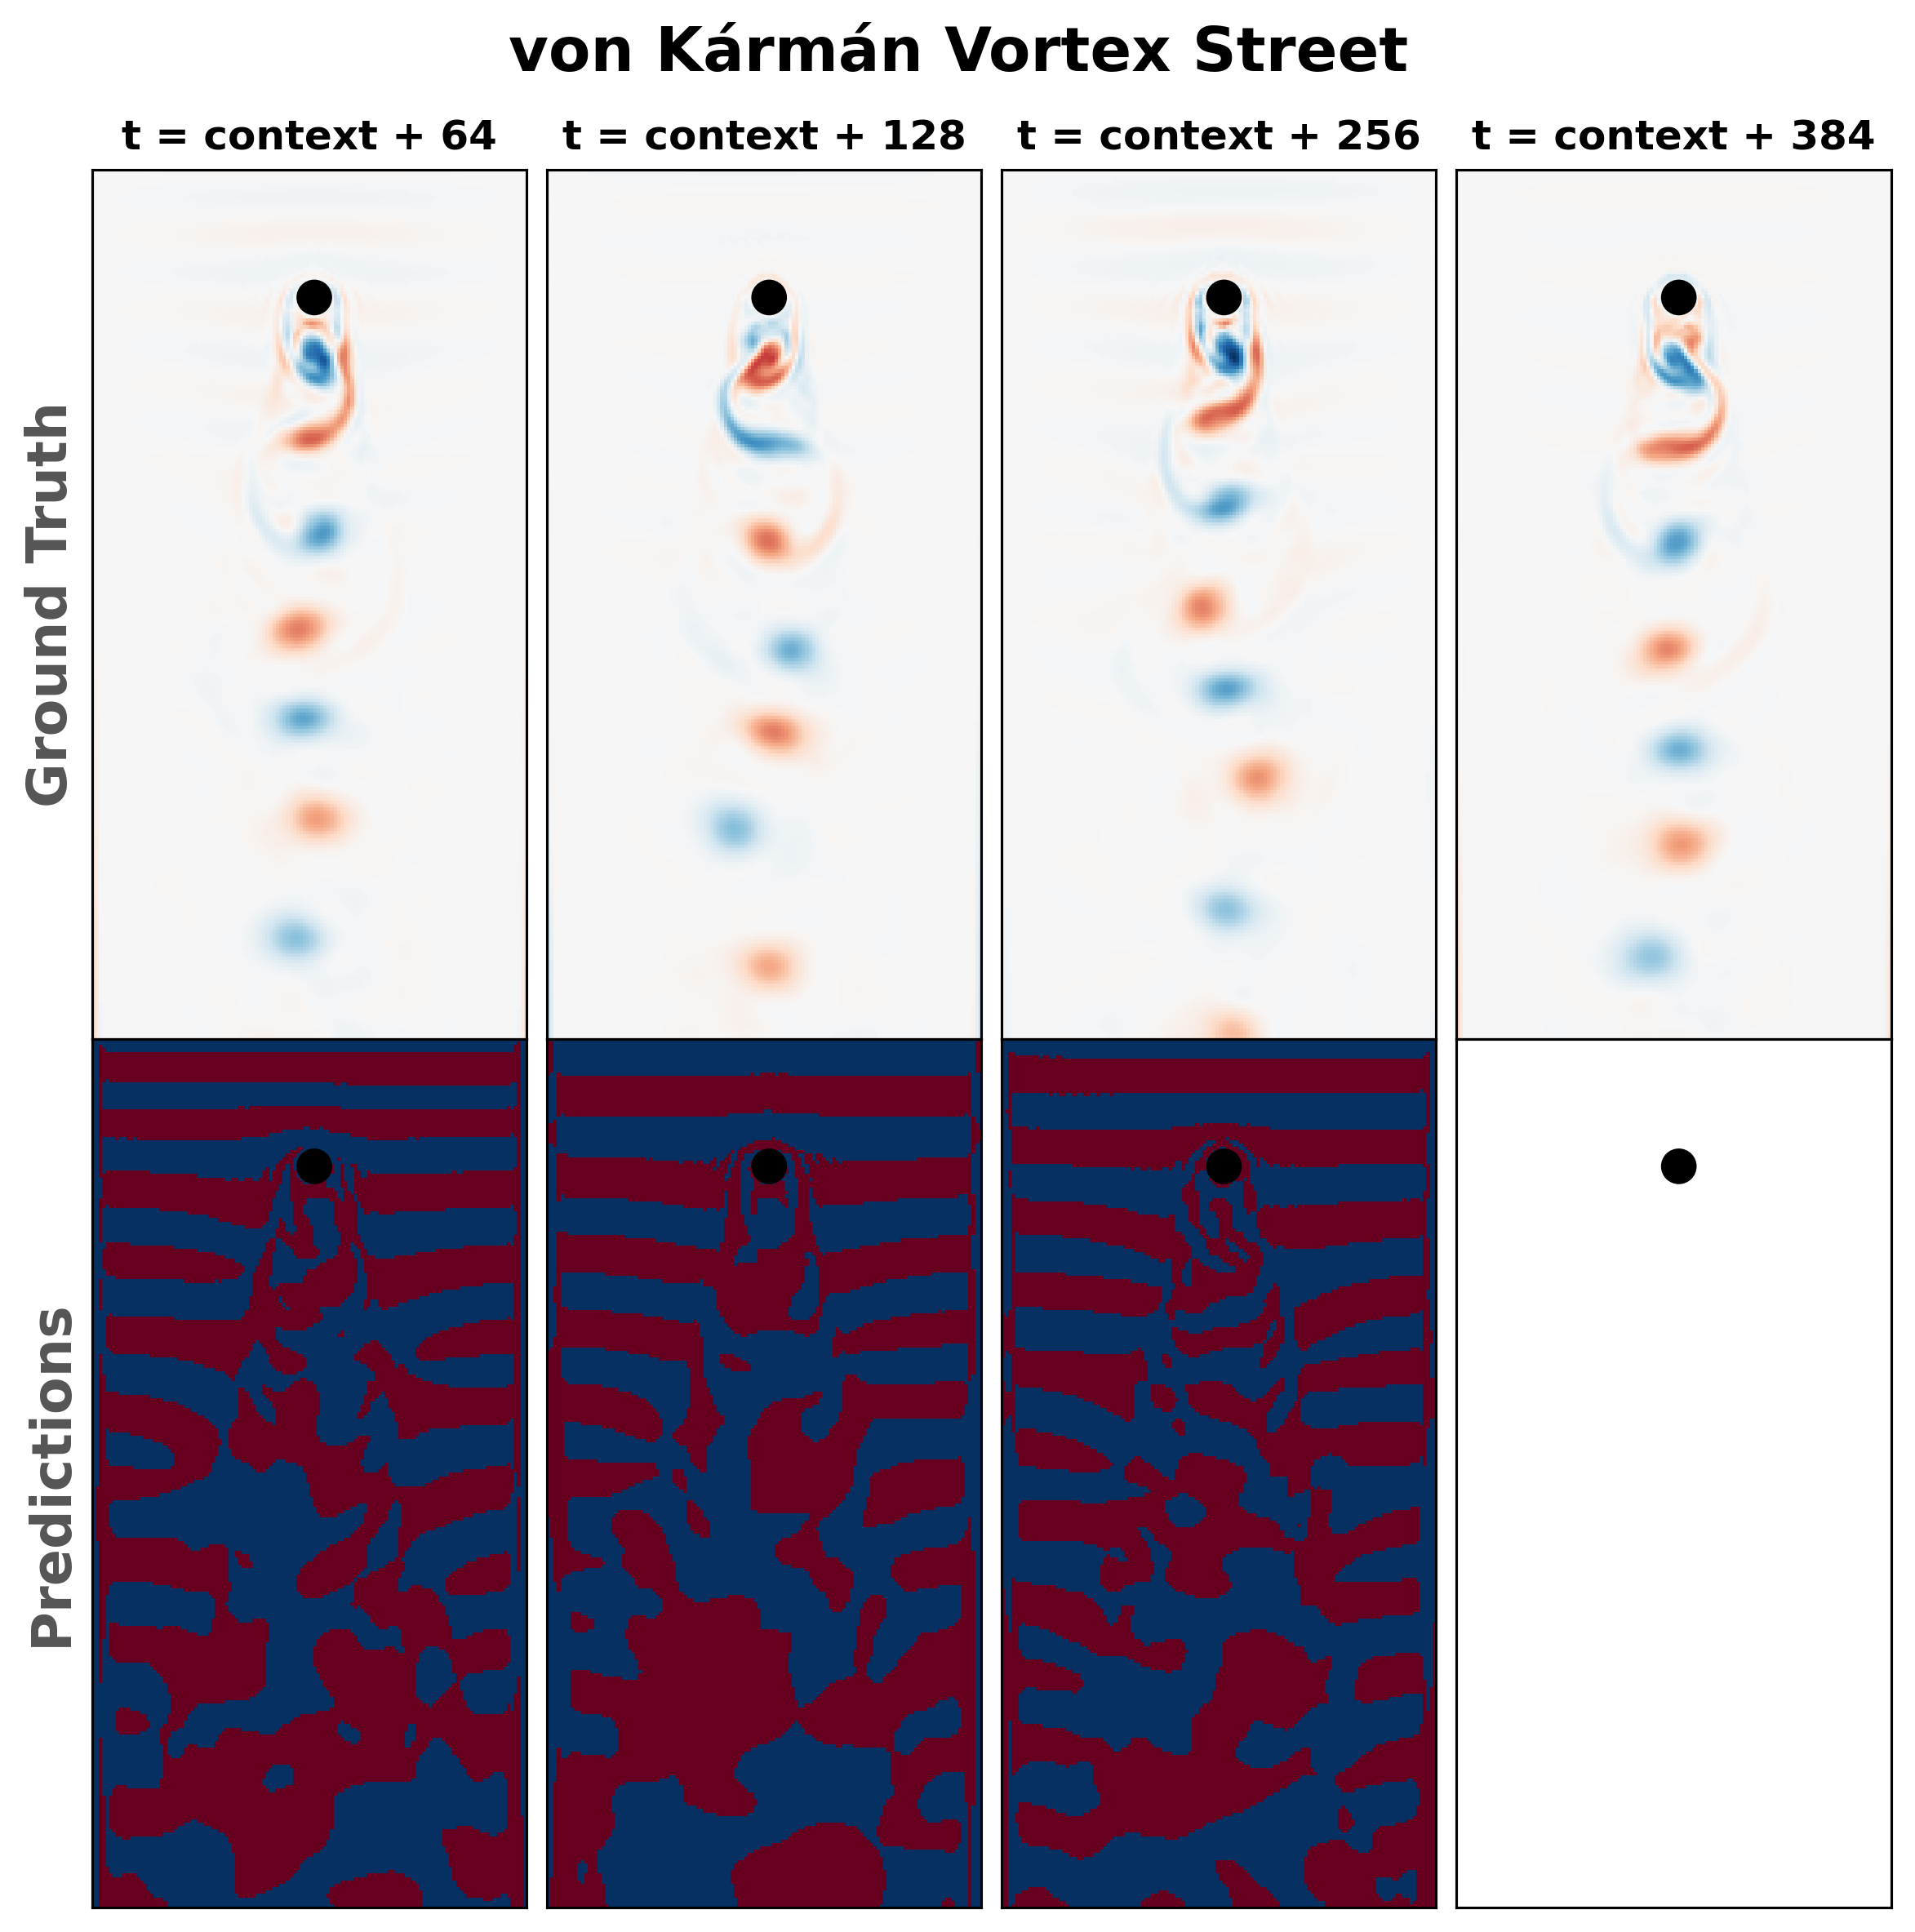

In [ ]:
plot_predicted_flow(
    prediction,
    trajs[0, context_length:],
    eigenvectors,
    num_modes=n_components,
    time_indices=[63, 127, 255, 383],
    cmap_name="RdBu",
    camera_ready=False,
    base_figsize=(4, 4),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)